# Softmax 回归

逻辑回归可以应用与二分类问题，使用 softmax 回归可以解决多分类问题。  
如果有三种类别，四种特征就可以写为（使用逻辑回归的方法）：  
$$
o_1 = x_1w_{11} + x_2w_{12}+x_3w_{13}+x_4w_{14}+b_1
$$
$$
o_2 = x_1w_{21} + x_2w_{22}+x_3w_{23}+x_4w_{24}+b_2
$$
$$
o_2 = x_1w_{31} + x_2w_{32}+x_3w_{33}+x_4w_{34}+b_3
$$

写成矩阵形式就是：
$$
O(x_1,x_2,x_3) = 
\begin{bmatrix} x_1
  & x_2  & x_3
\end{bmatrix} \cdot 
\begin{bmatrix} w_{11}
  & w_{12} & w_{13} \\ w_{21}
  & w_{22}  & w_{23} \\ w_{31}
  & w_{32}  & w_{33}
\end{bmatrix}^T
+ \begin{bmatrix} b_1
 \\b_2
 \\b_3

\end{bmatrix}
$$
也就是：
$$
o = x * w^T + b
$$

softmax回归的形式  
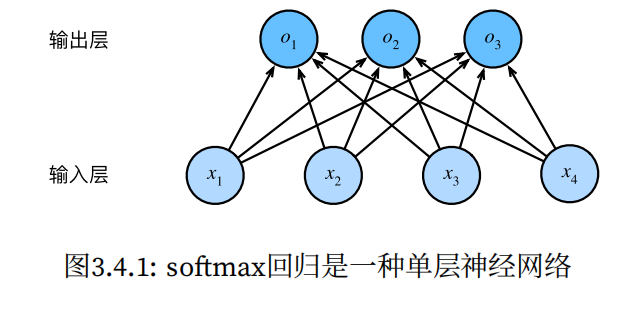

因为将线性层的输出直接视为概率时存在一些问题：一方面，我们没有限制这些输出数字的总和为1。另一方面，根据输入的不同，它
们可以为负值。所以后面使用softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持可导的性质。

softmax函数可以表示为：  
$$
\hat{y} = softmax(o)
$$
$$
\hat{y_j} = \frac{exp(o_j)}{\sum_kexp(o_k)}
$$

同样可以使用极大似然估计来得到其损失函数。  
$$
P(Y|X) = \prod^n_{i=1}P(y^i|x^i)
$$
最大化P(Y|x)相当于最小化负对数似然。  
$$
-logP(Y|X) = \sum^n_{i=1}-logP(y^i|x^i) = \sum^n_{i=1}l(y^i, \hat{y}^i)
$$
$$
l(y,\hat(y)) = -\sum^q_{j=1}y_ilog\hat{y_j}
$$

导入库

In [1]:
import torch
import torch.autograd
import matplotlib.pyplot as plt
import numpy as np
import dataset.fashion_mnist.utils.mnist_reader as mnist_reader
import tqdm


使用了 fashion-mnist 数据集，读取数据集并划分训练集和测试集

In [2]:
x_train, y_train = mnist_reader.load_mnist('dataset/fashion_mnist/data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('dataset/fashion_mnist/data/fashion', kind='t10k')

In [3]:
x_train = x_train.astype("float")
x_test = x_test.astype("float")
y_train = y_train.astype("float")
y_test = y_test.astype("float")

图片的标签

In [60]:
def get_fashion_mnist_labels(true_labels, yhat_labels = []):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    labels = []
    if len(yhat_labels) > 0:
        for i in range(true_labels.size()[0]):
            labels.append("true: " + text_labels[true_labels[i].int()] + " predict: " + text_labels[yhat_labels[i]])
    else:
        for i in range(true_labels.size()[0]):
            labels.append("true: " + text_labels[true_labels[i].int()])
    return labels

可视化

In [61]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=2):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img.reshape(28, 28))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'shirt'}>,
       <Axes: title={'center': 'coat'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 'coat'}>, <Axes: title={'center': 'bag'}>,
       

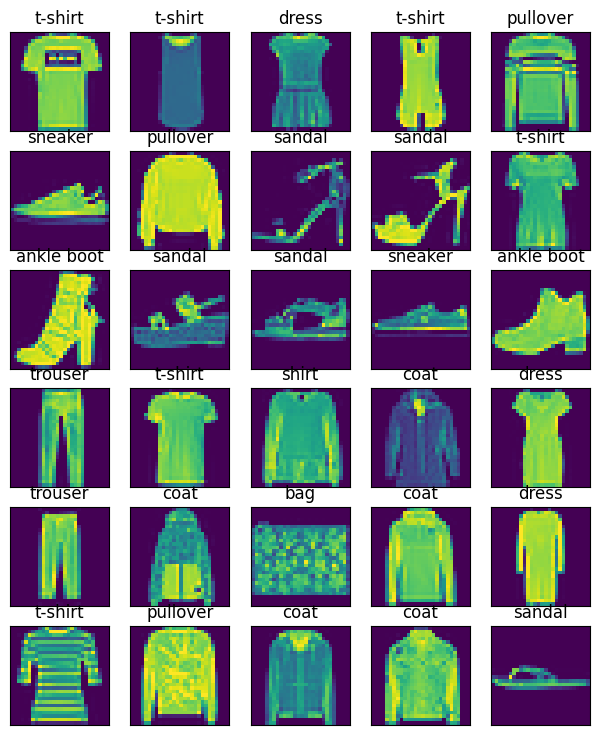

In [6]:
show_images(x_train[1:31], 6, 5, titles=get_fashion_mnist_labels(y_train[1:31]))

In [7]:
num_outputs = 10
num_inputs = 28 * 28

In [8]:
w = np.random.uniform(0, 0.001, size = (num_outputs, num_inputs))
b = np.random.uniform(0, 0.001, size = (num_outputs))

In [9]:
x_train = torch.tensor(x_train, requires_grad=True)
y_train = torch.tensor(y_train, requires_grad=True)
x_test = torch.tensor(x_test, requires_grad=True)
y_test = torch.tensor(y_test, requires_grad=True)
w = torch.tensor(w, requires_grad=True)
b = torch.tensor(b, requires_grad=True)

softmax函数

In [10]:
def f(x, w, b):
    return torch.mm(w, x.T) + b.view(-1, 1)

In [11]:
def softmax(x):
    c = x.max()
    x_exp = torch.exp(x - c)
    partition = x_exp.sum(dim=0, keepdim=True)
    return x_exp / partition

In [12]:
def net(X, w, b):
    return softmax(f(X, w, b))

In [13]:
def J(y, y_hat):
    return - y * torch.log(y_hat)

In [14]:
cur = net(x_train, w, b)
print(cur.shape)

torch.Size([10, 60000])


独热编码

In [15]:
y_train = torch.nn.functional.one_hot(y_train.to(torch.int64)) 

In [16]:
print(y_train.shape)
print(y_train)

torch.Size([60000, 10])
tensor([[0, 0, 0,  ..., 0, 0, 1],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


训练

In [17]:
lr = 0.181
n = x_train.size()[0]

for i in tqdm.tqdm(range(0, 200)):
    yhat = net(x_train, w, b)
    loss = J(y_train, yhat.T).sum() / n
    loss.backward()
    w.data = w.data - lr * w.grad.data / n
    b.data = b.data - lr * b.grad.data / n

100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


测试

In [19]:
yhat = net(x_test, w, b)
yhat = yhat.argmax(dim=0)
right_num = 0
n = y_test.size()[0]

for i in tqdm.tqdm(range(0, n)):
    if y_test[i] == yhat[i]:
        right_num = right_num + 1
print("准确率：%f %%" % ((right_num / n) * 100))

100%|██████████| 10000/10000 [00:00<00:00, 83540.06it/s]

准确率：80.340000 %


可视化部分预测的结果

array([<Axes: title={'center': 'true: pullover predict: pullover'}>,
       <Axes: title={'center': 'true: trouser predict: trouser'}>,
       <Axes: title={'center': 'true: trouser predict: trouser'}>,
       <Axes: title={'center': 'true: shirt predict: shirt'}>,
       <Axes: title={'center': 'true: trouser predict: trouser'}>,
       <Axes: title={'center': 'true: coat predict: coat'}>,
       <Axes: title={'center': 'true: shirt predict: shirt'}>,
       <Axes: title={'center': 'true: sandal predict: sandal'}>,
       <Axes: title={'center': 'true: sneaker predict: sneaker'}>,
       <Axes: title={'center': 'true: coat predict: coat'}>,
       <Axes: title={'center': 'true: sandal predict: sandal'}>,
       <Axes: title={'center': 'true: sneaker predict: sneaker'}>,
       <Axes: title={'center': 'true: dress predict: dress'}>,
       <Axes: title={'center': 'true: coat predict: coat'}>,
       <Axes: title={'center': 'true: trouser predict: trouser'}>,
       <Axes: title={'cente

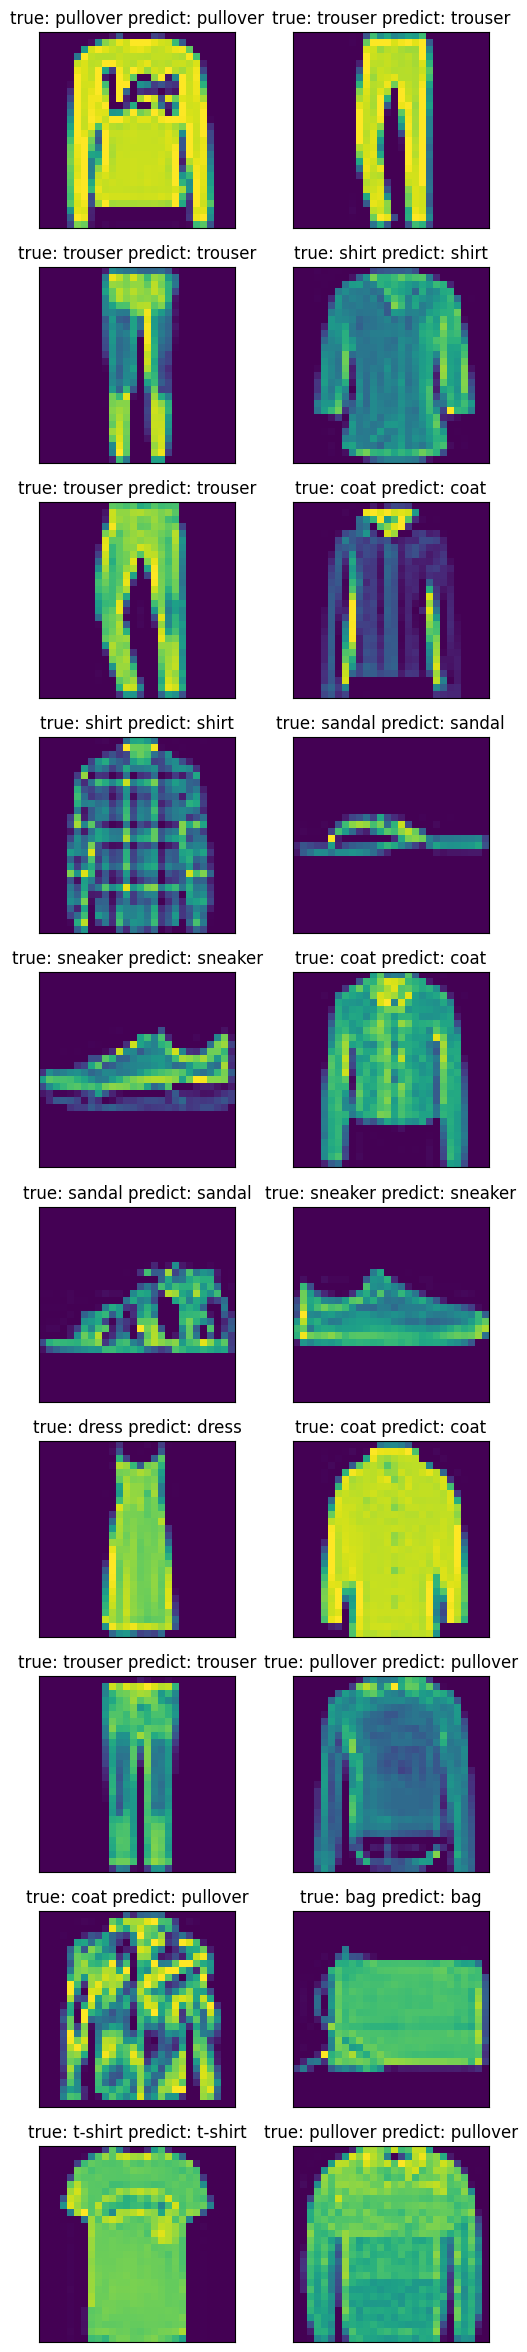

In [67]:
x_test = x_test.detach().numpy()
show_images(x_test[1:31], 10, 2, titles=get_fashion_mnist_labels(y_test[1:31], yhat[1:31]), scale=3)